##Catboost on Image and Text Embeddings 


Submitted by Akriti Gupta, Bhumika Singhal and Namita Shukla

In [3]:
!pip install catboost

In [4]:
#  Here we make all the imports required 
import pandas as pd
import numpy as np
import random, time
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix
from tqdm.notebook import tqdm, trange
import json

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


In [8]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Importing all the Embeddings of Text and Images reducing them to 100 dim using PCA. 

In [9]:
concat_embeddings = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/roberta_retrain_1_ConcatEmbeddings_train.csv")
concat_embeddings.rename(columns={"0": "id"}, inplace=True)

In [10]:
concat_embeddings_val = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/roberta_retrain_1_ConcatEmbeddings_dev_unseen.csv")
concat_embeddings_val.rename(columns={"0": "id"}, inplace=True)

In [11]:
concat_embeddings_test_unseen = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/roberta_retrain_1_ConcatEmbeddings_test_unseen.csv")
concat_embeddings_test_unseen.rename(columns={"0": "id"}, inplace=True)
concat_embeddings_test_seen = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/roberta_retrain_1_ConcatEmbeddings_test_seen.csv")
concat_embeddings_test_seen.rename(columns={"0": "id"}, inplace=True)

Importing all the JSON Files 

In [12]:
train_data = pd.read_json("/content/gdrive/MyDrive/522-project/train.jsonl", lines=True)
train_data.head()
train_data.shape
# batch_size = 32
# chunked_data = split_dataframe(train_data, batch_size)

(8500, 4)

In [13]:
val_data = pd.read_json("/content/gdrive/MyDrive/522-project/dev_unseen.jsonl", lines=True)
val_data.head()
val_data.shape

(540, 4)

In [14]:
test_unseen_data = pd.read_json("/content/gdrive/MyDrive/522-project/test_unseen.jsonl", lines=True)
test_unseen_data.head()
test_unseen_data.shape

(2000, 4)

In [15]:
test_seen_data = pd.read_json("/content/gdrive/MyDrive/522-project/test_seen.jsonl", lines=True)
test_seen_data.head()
test_seen_data.shape

(1000, 4)

In [16]:
train_embed = concat_embeddings[concat_embeddings.id.isin(train_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
target_train = train_data["label"].tolist()
print(len(train_embed))

8500


In [17]:
val_embed= concat_embeddings_val[concat_embeddings_val.id.isin(val_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
val_target = val_data["label"].tolist()
len(val_embed)

540

In [18]:
test_unseen_embed= concat_embeddings_test_unseen[concat_embeddings_test_unseen.id.isin(test_unseen_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
test_unseen_target = test_unseen_data["label"].tolist()
len(test_unseen_embed)
len(test_unseen_target)

2000

In [19]:
test_seen_embed= concat_embeddings_test_seen[concat_embeddings_test_seen.id.isin(test_seen_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
test_seen_target = test_seen_data["label"].tolist()
len(test_seen_embed)

1000

## Fitting the cocatenated Train embedding on the Catboost Model

We fine tuned the catboost model on various parameters such as :  

1. training iterations
2. regularization penalties of l2.
3. iterations
4. learning rate



In [20]:
train_embed = np.array(train_embed)
target_train = np.array(target_train)
val_embed = np.array(val_embed)
val_target = np.array(val_target)

In [21]:
import sklearn.metrics as metrics
clf = CatBoostClassifier(
    iterations=100, 
    learning_rate=0.5, 
    loss_function='CrossEntropy',
    depth=3,
    l2_leaf_reg = 2,
    grow_policy= "Depthwise",
    random_strength = 0.1,
    od_type = 'IncToDec'  
)

clf.fit(train_embed, target_train)
# pred_y_cb_val = clf.predict(val_embed)
# pred_y_cb_train =  clf.predict(train_embed)

0:	learn: 0.6404014	total: 460ms	remaining: 45.6s
1:	learn: 0.6174312	total: 869ms	remaining: 42.6s
2:	learn: 0.6057123	total: 1.26s	remaining: 40.6s
3:	learn: 0.5958172	total: 1.66s	remaining: 39.9s
4:	learn: 0.5874822	total: 2.06s	remaining: 39.1s
5:	learn: 0.5794425	total: 2.46s	remaining: 38.5s
6:	learn: 0.5722573	total: 2.86s	remaining: 38s
7:	learn: 0.5650735	total: 3.24s	remaining: 37.3s
8:	learn: 0.5588502	total: 3.66s	remaining: 37s
9:	learn: 0.5511228	total: 4.06s	remaining: 36.5s
10:	learn: 0.5452989	total: 4.44s	remaining: 35.9s
11:	learn: 0.5398124	total: 4.85s	remaining: 35.6s
12:	learn: 0.5329106	total: 5.37s	remaining: 35.9s
13:	learn: 0.5264737	total: 5.77s	remaining: 35.5s
14:	learn: 0.5205662	total: 6.16s	remaining: 34.9s
15:	learn: 0.5150534	total: 6.56s	remaining: 34.4s
16:	learn: 0.5091066	total: 6.95s	remaining: 33.9s
17:	learn: 0.5038902	total: 7.31s	remaining: 33.3s
18:	learn: 0.4990688	total: 7.72s	remaining: 32.9s
19:	learn: 0.4941298	total: 8.07s	remaining: 

## Testing on the Validation Set

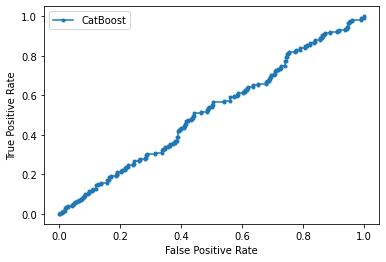

precision :0.38181818181818183 recall :0.21 f1 :0.2709677419354839 accuracy :0.5814814814814815


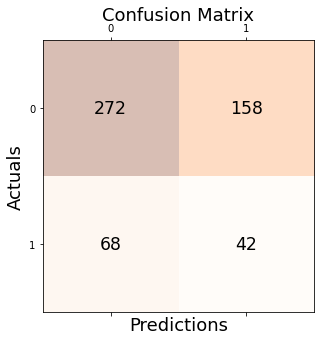

Precision vs Recall


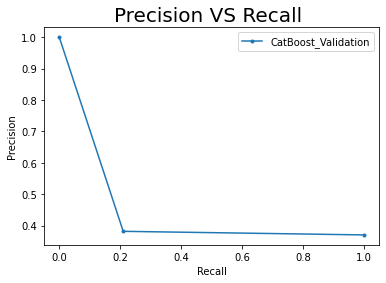

In [22]:
preds = clf.predict(val_embed)
lr_probs = clf.predict_proba(val_embed) 
lr_probs = lr_probs[:, 1]

lr_auc = roc_auc_score(val_target, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(val_target, lr_probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='CatBoost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
precision, recall, f1, _ = precision_recall_fscore_support(val_target, preds, average='binary')
acc = accuracy_score(val_target, preds)
r = confusion_matrix(preds, val_target)
print("precision :"+str(precision) +" recall :"+str(recall)+" f1 :"+ str(f1)  + " accuracy :" + str(acc))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
print("Precision vs Recall")
precision1, recall1, thresholds = precision_recall_curve(val_target, preds)
pyplot.plot(recall1, precision1, marker='.', label='CatBoost_Validation')
# axis labels
pyplot.title('Precision VS Recall ', fontsize=20)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [23]:
print("ROC Curve : " + str(lr_auc))

ROC Curve : 0.5167205882352941


## Testing on Test Seen Data

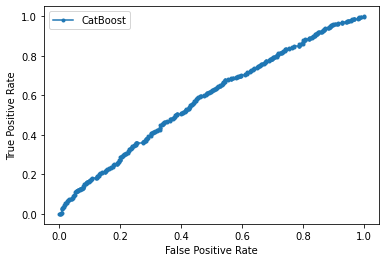

precision :0.5810276679841897 recall :0.3 f1 :0.395693135935397 accuracy :0.551


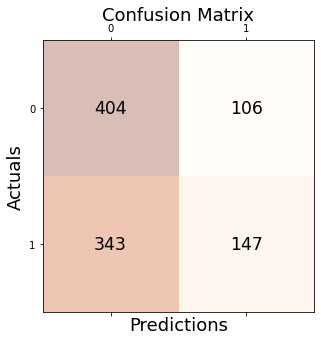

Precision vs Recall


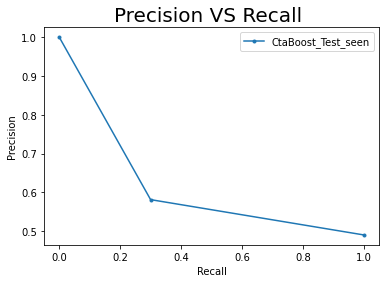

In [24]:
preds = clf.predict(test_seen_embed)
lr_probs = clf.predict_proba(test_seen_embed) 
lr_probs = lr_probs[:, 1]

lr_auc = roc_auc_score(test_seen_target, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_seen_target, lr_probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='CatBoost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
precision, recall, f1, _ = precision_recall_fscore_support(test_seen_target, preds, average='binary')
acc = accuracy_score(test_seen_target, preds)

r = confusion_matrix(test_seen_target, preds)
print("precision :"+str(precision) +" recall :"+str(recall)+" f1 :"+ str(f1)  + " accuracy :" + str(acc))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
print("Precision vs Recall")
precision1, recall1, thresholds = precision_recall_curve(test_seen_target, preds)
pyplot.plot(recall1, precision1, marker='.', label='CtaBoost_Test_seen')
# axis labels
pyplot.title('Precision VS Recall ', fontsize=20)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [25]:
print("ROC Curve : " + str(lr_auc))

ROC Curve : 0.5816366546618648


## Testing on the unseen test data

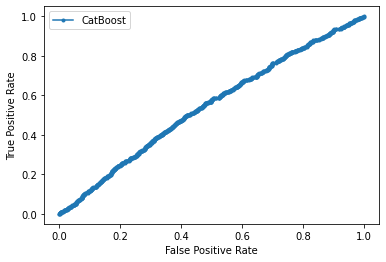

precision :0.41397849462365593 recall :0.308 f1 :0.3532110091743119 accuracy :0.577


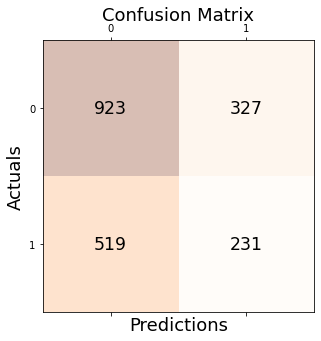

Precision vs Recall


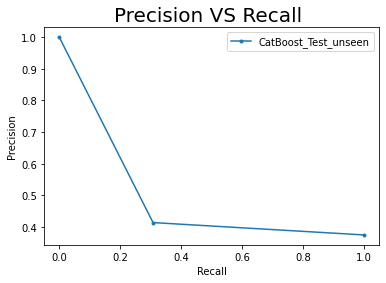

In [26]:
preds = clf.predict(test_unseen_embed)
lr_probs = clf.predict_proba(test_unseen_embed) 
lr_probs = lr_probs[:, 1]

lr_auc = roc_auc_score(test_unseen_target, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_unseen_target, lr_probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='CatBoost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
precision, recall, f1, _ = precision_recall_fscore_support(test_unseen_target, preds, average='binary')
acc = accuracy_score(test_unseen_target, preds)
r = confusion_matrix(test_unseen_target, preds)
print("precision :"+str(precision) +" recall :"+str(recall)+" f1 :"+ str(f1)  + " accuracy :" + str(acc))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

precision1, recall1, thresholds = precision_recall_curve(test_unseen_target, preds)
print("Precision vs Recall")
pyplot.plot(recall1, precision1, marker='.', label='CatBoost_Test_unseen')
# axis labels
pyplot.title('Precision VS Recall ', fontsize=20)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [27]:
print("ROC Curve : " + str(lr_auc))

ROC Curve : 0.5438133333333333
